# DSCI 100 Final Group Project

# Predicting Newsletter Subscription Using Age and Gameplay Hours

Group 37- Jaana Rodrigo, Matthew Kyi, Mersara Shi

# Introduction

**<p style="color: green;">J- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report</p>**

### Background

Video games generate and store large amounts of behavioural data whcih can be used to understand how players interact with games and game- realted activities. At UBC, a lab led by Frank Wood runs a customized Minecraft research server that records player activity as they explore and interact with the game. Each unique player is logged in the players.csv dataset, which includes a list of all players and some of their basic information.

**<p style="color: pink;">Mer- Clearly state the question you tried to answer with your project**

### Research Question

Can player's age and the total hours played be used to predict whether they subscribe to the game-related newsletter in the *players* dataset?

We will be using the explanatory variables **played_hours** (dbl) and **Age** (dbl) to predict whether a player subscribes to a newsletter.

Response Variable: subscribe (TRUE/FALSE)
Explanatory Variables: played_hours (dbl), Age (dbl) (move this part to methods)

**<p style="color: green;">Mat- identify and fully describe the dataset that was used to answer the question</p>**

<p>We will be making use of the players.csv dataset to answer our question. Below, we load the players.csv dataset, and show the first six observations.</p>

### Data Inspection

In [84]:
# Load necessary libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(themis)
library(ggplot2)
library(dplyr)
library(tidyr)

# Set display options for readability
options(repr.matrix.max.rows = 7)

In [85]:
# Load players dataset
download.file(url = "https://raw.githubusercontent.com/MatthewKyi/DSCI100-004-37/refs/heads/main/players.csv", destfile = "players-local.csv")
players <- read_csv("players-local.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1 Pro         TRUE    
2 Veteran     TRUE    
3 Veteran    FALSE    
4 Amateur     TRUE    
5 Regular     TRUE    
6 Amateur     TRUE    
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender Age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

### Describing the variables in the players dataset

In the players dataset, there is a total of 196 observations (rows). This corresponds to 196 unique player accounts (each account has a unique hashedEmail). The players dataset contains a total of 7 variables, each storing information about a player.

Variables: 7

1. experience (chr)- Player's skill level.

2. hashedEmail (chr)- Player's email, hashed for privacy.

3. name (chr)- Player's name.

4. gender (chr)- Player's self- identified gender.

5. played_hours (dbl)- Number of hours played.

6. Age (dbl)- Age of the player.

7. subscribe (lgl)- Newsletter subscription status

We identified two potential issues with the players dataset. Firstly, many of the values in the played_hours column are 0 due to inactive players. Secondly, the dataset has some extreme values/outliers that may affect our results in unwanted ways.

# Methods and Results

<p style="color: orange;">J-describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:</p>
<p style="color: pink;">Mer-load data<br><br>
<span style="color: green;">Mat-wrangles and cleans the data to the format necessary for the planned analysis</span><br><br>
<p style="color: green;">J-performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis </p><br>
<p style="color: pink;">Mer-creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis<br><br>

Mat-performs the data analysis<br><br>
J-creates a visualization of the analysis <br><br>
note: all figures should have a figure number and a legend</p></p>

In the section above, we loaded the necessary libraries and loaded in the player.csv dataset. 

Next, we wrangled and cleaned the data to prepare it for modelling. This included
1. Removing NA values
2. Renaming variables
3. Selecting relevant columns
4. Mutating subscribe column to aid in clarity

### Data Cleaning & Wrangling

In [58]:
# wrangle and clean data to the format necessary for the planned analysis
players_tidy <- players |>
  drop_na() |> # remove rows with NA values
  rename(hashed_email = hashedEmail, age = Age) |>
  select(age, played_hours, subscribe) |>
  mutate(subscribe = as_factor(subscribe)) |>
  mutate(subscribe = fct_recode(subscribe, "Subscriber" = "TRUE", "Non- subscriber" = "FALSE"))

players_tidy

age played_hours subscribe      
1    9  30.3         Subscriber     
2   17   3.8         Subscriber     
3   17   0.0         Non- subscriber
4   21   0.7         Subscriber     
⋮   ⋮   ⋮            ⋮              
192 22  0.3          Non- subscriber
193 57  0.0          Non- subscriber
194 17  2.3          Non- subscriber

### Summarizing and Exploring the data

To understand the dataset, we conducted exploratory analysis. 

First we generated numerical summaries of the variables we plan to use in our analysis. 

For the subscription status, we obtained the count and percentage values. 

For the number of hours played and age, we found the min, mean, median and max. 

In [59]:
#Count and percentage of each subscription status
subscribe_counts <- players |>
  count(subscribe) |>
  rename(subscription_status = subscribe, count = n) |>
  mutate(percentage = round((count / sum(count)) * 100, 2))

subscribe_counts

subscription_status count percentage
1 FALSE                52   26.53     
2  TRUE               144   73.47

In [60]:
#Minimum, mean, median and maximum values for Hours Played
played_hours_summary <- players |>
  summarise(
    min = round(min(played_hours, na.rm = TRUE), 2),
    mean = round(mean(played_hours, na.rm = TRUE), 2),
    median = round(median(played_hours, na.rm = TRUE), 2),
    max = round(max(played_hours, na.rm = TRUE), 2)
  ) |>
  pivot_longer(everything(), names_to = "stat", values_to = "played_hours") |>
  as_tibble()

played_hours_summary

stat   played_hours
1 min      0.00      
2 mean     5.85      
3 median   0.10      
4 max    223.10

In [61]:
#Minimum, mean, median and maximum values for Age
age_summary <- players |>
  summarise(
    min = round(min(Age, na.rm = TRUE), 2),
    mean = round(mean(Age, na.rm = TRUE), 2),
    median = round(median(Age, na.rm = TRUE), 2),
    max = round(max(Age, na.rm = TRUE), 2)
  ) |>
  pivot_longer(everything(), names_to = "stat", values_to = "Age") |>
  as_tibble()

age_summary

stat   Age  
1 min     9.00
2 mean   21.14
3 median 19.00
4 max    58.00

### Exploratory Scatterplot

Next, we drew a scatter plot to visualize and inspect the relationship between the Subscription Status, Age and Playtime variables.

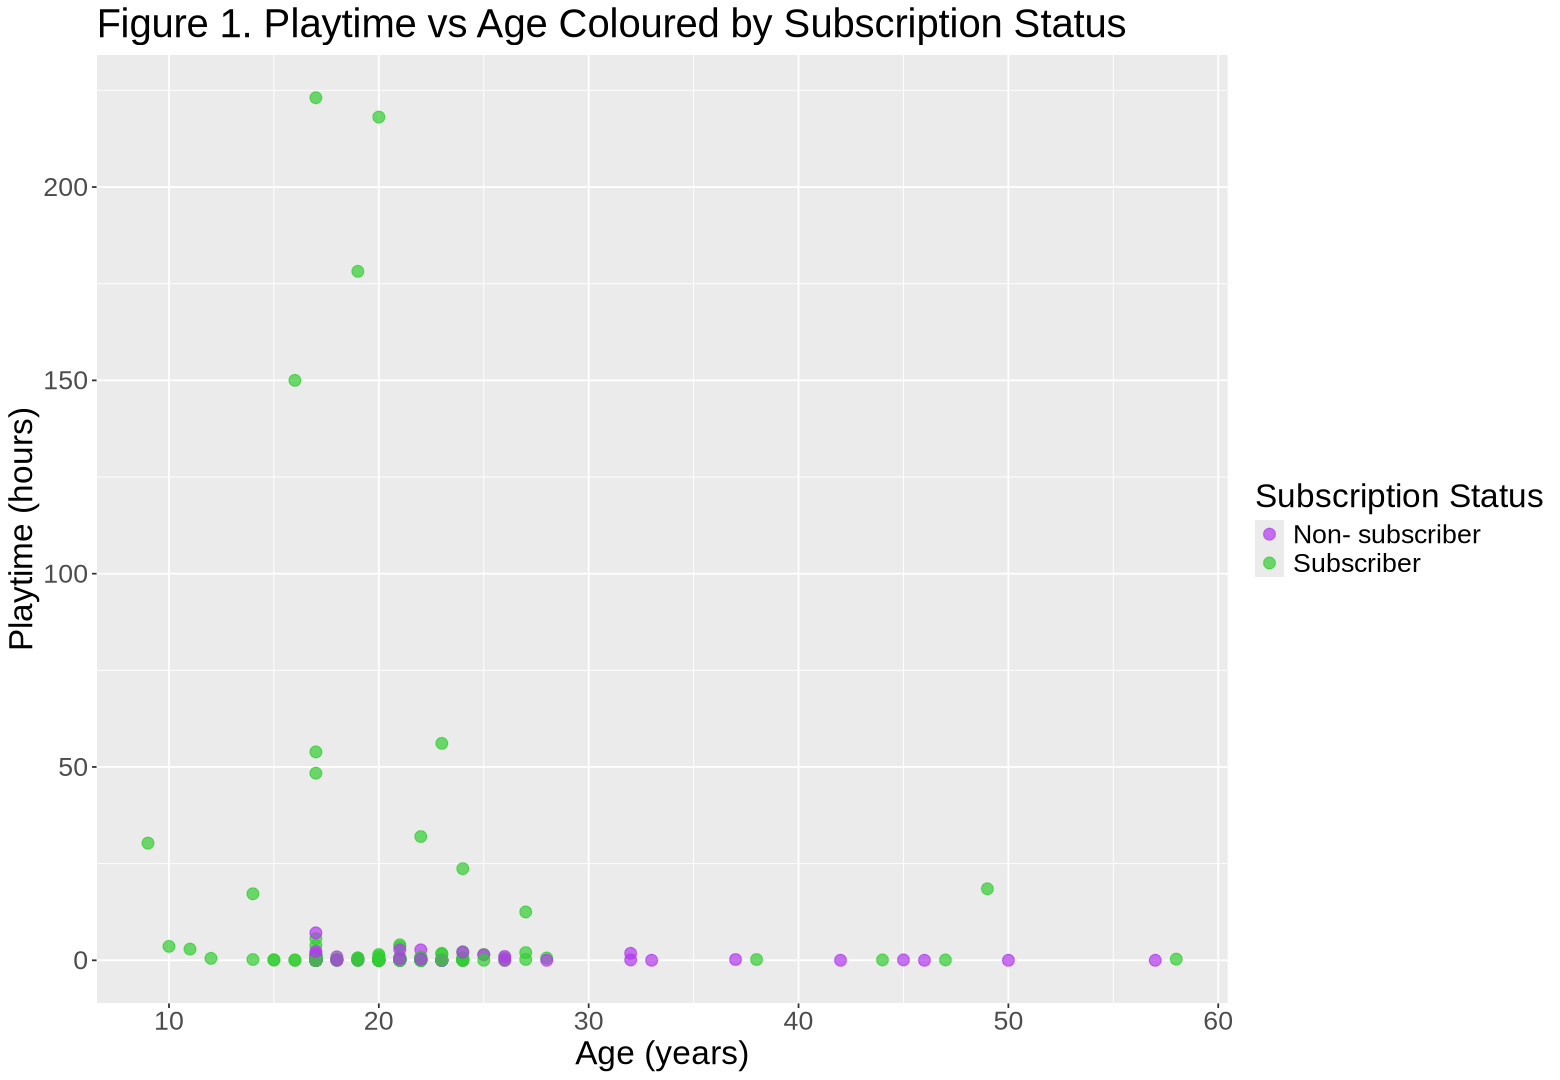

In [94]:
options(repr.plot.width = 13, repr.plot.height = 9)
ggplot(players_tidy, aes(x = age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.7, size = 3) +
  labs(
    title = "Figure 1. Playtime vs Age Coloured by Subscription Status",
    x = "Age (years)",
    y = "Playtime (hours)",
    color = "Subscription Status") +
 scale_color_manual(values = c("darkorchid2", "limegreen")) +
theme(text = element_text(size = 20))

Most non-subscribers have low playtimes, suggesting that players who do not subscribe tend to be less engaged with the server overall. A few inactive players are subscribed, which indicates that subscription status is usally associated with ongoing interest, despite low activity. Interestingly, all players under age 17 are subscribed, pointing toward an age related trend in subscription behaviour. We can better examine the relationship between age and subscription status in figure 2.

### Exploratory Histogram

We also drew a histogram to visualize the distribution of age and subscription status.

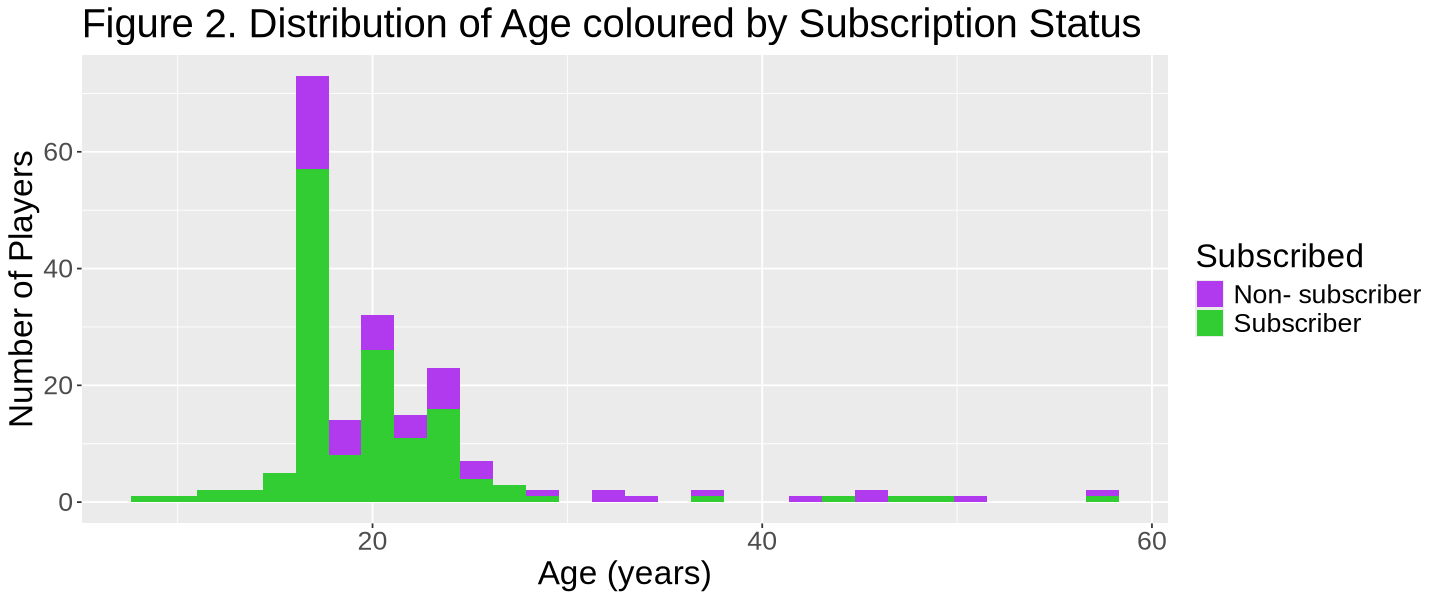

In [95]:
options(repr.plot.width = 12, repr.plot.height = 5)

ggplot(players_tidy, aes(x = age, fill = subscribe)) +
  geom_histogram(bins = 30, position = "stack") +
  labs(
    title = "Figure 2. Distribution of Age coloured by Subscription Status",
    x = "Age (years)",
    y = "Number of Players",
    fill = "Subscribed" ) +
 scale_fill_manual(values = c("darkorchid2", "limegreen")) +
theme(text = element_text(size = 20))

The distribution graph shows that subscription rates are highest among younger players, especially those under 20. Within this age group, majority of players are subscribers, while non-subscribers are relatively rare. In contrast, older players show lower subscription rates. This pattern suggests that age may be a meaningful predictor of newsletter subscription, with younger players demonstrating stronger engagement or interest.

### Data Analysis

We chose to use the K- Nearest Neighbors 

In [64]:
# set random seed for reproducibility
set.seed(1234)

To evaluate the model performance, we split the data into training and testing using a stratified 75/25 split.

In [65]:
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

We then created a 5- fold cross- validation on the training set, also stratified.

In [66]:
# create 5-fold cross-validation object
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

Preprocessing Data: 

To prepare predictors for modeling, we constructed a recipe to standardize the numerical variables.

In [67]:
# define recipe
players_recipe <- recipe(subscribe ~ age + played_hours,
                        data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  step_smote(subscribe)

We then created the model specification, calling the nearest_nighbor function, specifying that each neighboring point should have the same weight when voting and using a tunable number of neighbors. We also specified the package as kknn and the type of prediction as classification.

In [68]:
# define KNN model specification with tunable neighbors
knn_spec <- nearest_neighbor(weight_func = "optimal",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

We defined the range of k values and proceeeded to perform grid search cross- validation to evaluate the accuracy of each k value.

In [69]:
# define range of k values to try
k_vals <- tibble(neighbors = seq(from = 5, to = 40, by = 2))

# tune KNN model over the range of k values with cross-validation
knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

We then extracted and ranked the accuracy metrics.

In [70]:
# display accuracies for best k values
accuracies <- knn_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))

head(accuracies)

neighbors .metric  .estimator mean      n std_err    .config              
1 37        accuracy binary     0.6209688 5 0.03142329 Preprocessor1_Model17
2 27        accuracy binary     0.6140722 5 0.02606204 Preprocessor1_Model12
3 23        accuracy binary     0.6138424 5 0.01937978 Preprocessor1_Model10
4 25        accuracy binary     0.6071757 5 0.02159077 Preprocessor1_Model11
5 29        accuracy binary     0.6069458 5 0.01675174 Preprocessor1_Model13
6 31        accuracy binary     0.6069458 5 0.01675174 Preprocessor1_Model14

Next, the results were visualized in a line graph, plotting accuracy estimates against the number of neighbors (K).

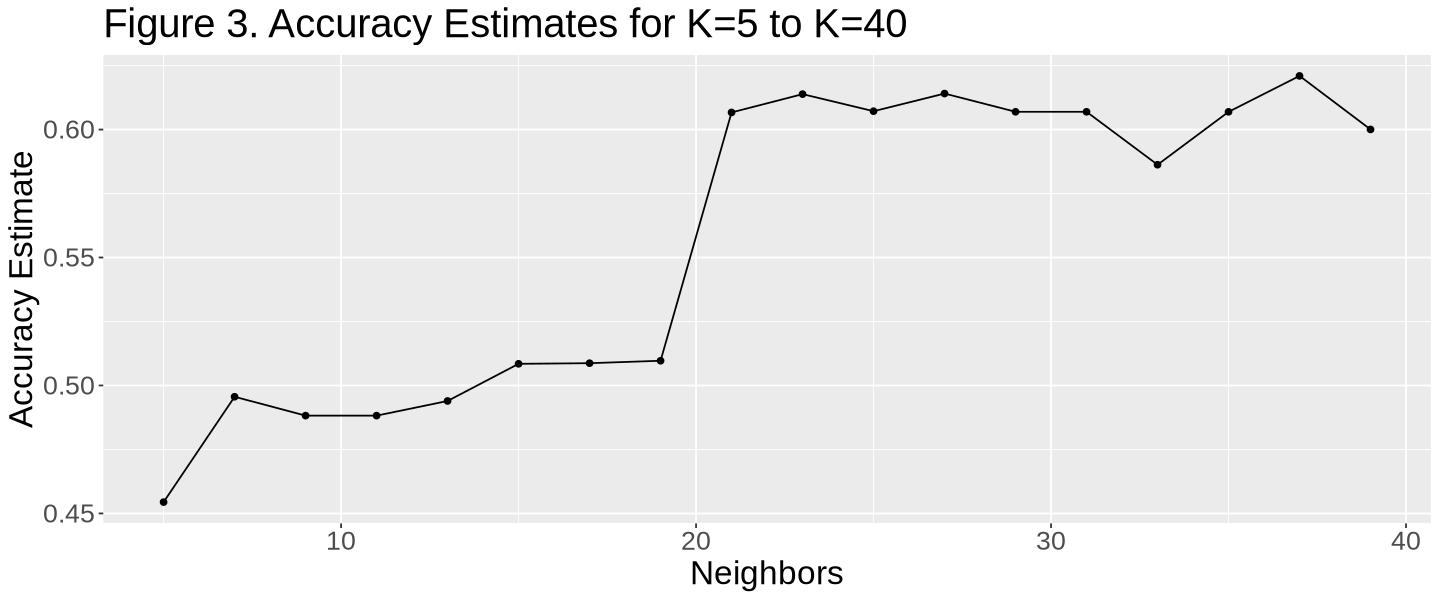

In [77]:
# generate plot of accuracy estimates vs. k values
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 3. Accuracy Estimates for K=5 to K=40",
      x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20))

accuracy_vs_k

The k value with the highest accuracy estimate was then selected and used to finalize and fit the model:

In [78]:
# get best k value
best_k <- accuracies |>
        pull(neighbors) |>
        head(1)
        
best_k

[1] 37

We refit the model with the best K value and rebuild the workflow using our old recipe and new model specification.

In [79]:
# finalize KNN model with best k value and fit to training data
knn_spec <- nearest_neighbor(weight_func = "optimal", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

We then used the trained model to maek predictions on our test data, and calculated the model's accuracy

In [80]:
# make predictions on test set and evaluate accuracy
players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric  .estimator .estimate
1 accuracy binary     0.6122449

To further evaluate model performance, we generated a confusion matrix using the predicted class labels from the test set and the true subscription outcomes.

In [81]:
# generate confusion matrix
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

                 Truth
Prediction        Non- subscriber Subscriber
  Non- subscriber               6         12
  Subscriber                    7         24

Finally, we selected the best k by choosing the value that yielded the highest cross- validated accuracy on the training set.

In [82]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1)
best_k

neighbors .metric  .estimator mean      n std_err    .config              
1 37        accuracy binary     0.6209688 5 0.03142329 Preprocessor1_Model17

### Data Analysis Visualization

To visualize our analysis, we created a colored prediction map visualization

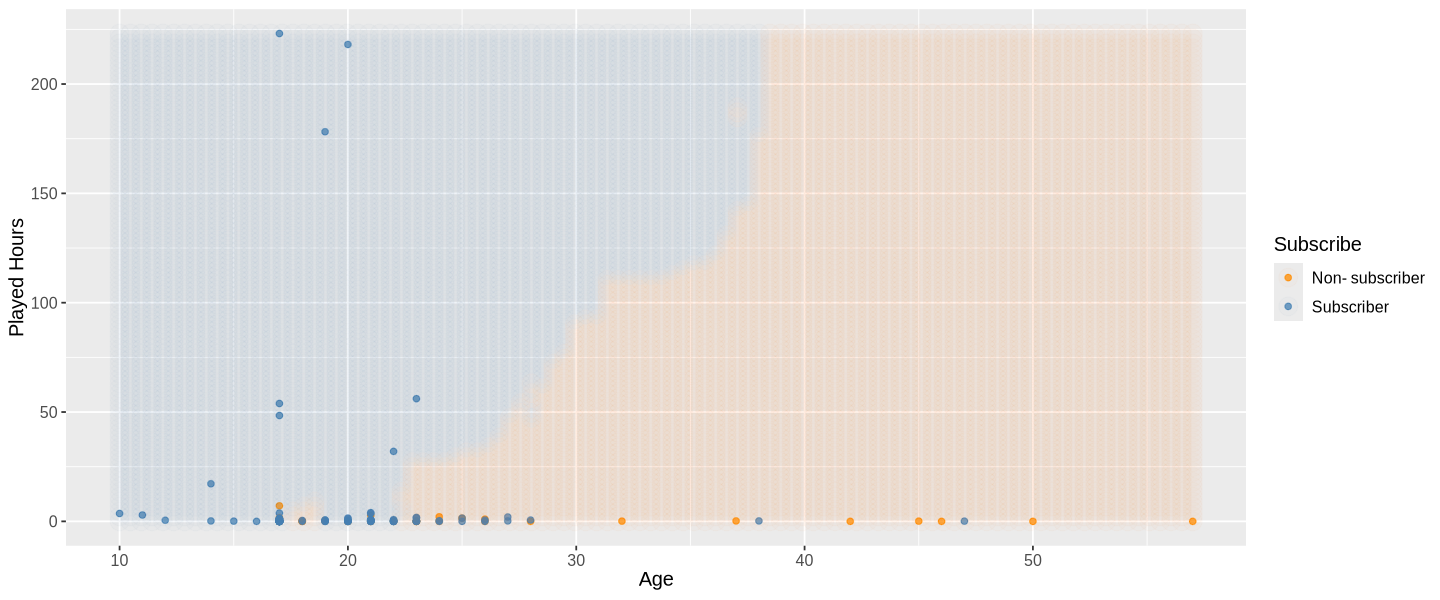

In [91]:
age_grid <- seq(min(players_train$age),
                max(players_train$age),
                length.out = 100)
hours_grid <- seq(min(players_train$played_hours),
                  max(players_train$played_hours),
                  length.out = 100)

grid <- as_tibble(expand.grid(age = age_grid,
                              played_hours = hours_grid))

knnPredGrid <- predict(knn_fit, grid)

prediction_table <- bind_cols(knnPredGrid, grid) |>
  rename(Subscribe = .pred_class)

decision_plot <- ggplot() +
  geom_point(data = players_train,
             aes(x = age, y = played_hours, color = subscribe),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             aes(x = age, y = played_hours, color = Subscribe),
             alpha = 0.02, size = 5) +
  labs(color = "Subscribe",
       x = "Age",
       y = "Played Hours") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

decision_plot

# Discussion

### Suitability
KNN classification is appropriate because it handles binary response variables and continuous explanatory variables. 
### Assumptions
- Observations are independent
- Balanced dataset
- Sufficient sample size

### Limitations and Weaknesses
KNN requires continuous variables, we cannot use player experience and gender as exploratory variables. It is also sensitive to outliers and class imbalance. it is also highly dependent on k, which must be carefully selected to avoid overfitting or underfitting.

### Comparison and Model Selection

I would tune k using k-fold cross-validation.

### Data processing
1. Standardization of played_hours and Age
2. Splitting (75 training/ 25 testing)
3. Cross validation

**Mer - summarize what you found <br><br>
Mat - discuss whether this is what you expected to find <br><br>
J - discuss what impact could such findings have <br><br>
Mer - discuss what future questions could this lead to**